## 多输入通道

In [1]:
import torch
from d2l import torch as d2l

# 计算多输入通道，单输出通道的互相关运算
def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起。 X与K具有相同的输入通道数
    # 输出通道数为 1 
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [2]:
X = torch.tensor([[[0.0, 1.0, 2.0], 
                   [3.0, 4.0, 5.0], 
                   [6.0, 7.0, 8.0]],
                  
                  [[1.0, 2.0, 3.0], 
                   [4.0, 5.0, 6.0], 
                   [7.0, 8.0, 9.0]]])

K = torch.tensor([[[0.0, 1.0], 
                   [2.0, 3.0]], 
                  
                  [[1.0, 2.0], 
                   [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 多输出通道

In [3]:
# K是四维的 (c_o, c_i, k_h, k_w) 每个输出通道都有对应每个输入通道数量的卷积核
# X是三维的 (c_i, n_h, n_w)
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度(c_o)，每次都对输入“X”执行互相关运算。 因此迭代后产生c_o个矩阵，压在一起，因此输出有多通道(c_o, h, w)
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [4]:
# 将K, K+1, K+2 叠在一起，构造出了3个输出通道的四维卷积核
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [7]:
corr2d_multi_in_out(X, K) # 三维的输出(c_o, h, w)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## 1x1的卷积层
1x1的卷积层失去了卷积层的特有能力——在高度和宽度维度上，识别相邻元素间相互作用的能力。1x1卷积的唯一计算发生在通道上。
> 我们可以将1x1的卷积层看作在每个像素位置应用的全连接层，最终将c_i个通道的输入，变为c_o个通道的输出，其中h、w不变。1x1卷积层需要的权重维度为（c_o * c_i）再加上额外的偏置，因为一个1x1卷积核只对应一个参数

In [8]:
# 此函数相当于实现了1x1卷积核的运算
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    # 我们需要对输入和输出的数据形状进行调整
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层的矩阵乘法
    Y = torch.matmul(K, X) # 不同输入通道同一像素位置的各元素与不同输出通道的1x1卷积核权重的线性组合
    return Y.reshape((c_o, h, w)) # 输出三维张量

In [10]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K) # （2, 3, 3） 
Y2 = corr2d_multi_in_out(X, K) # （2, 3, 3）
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6
Y1.shape, Y2.shape

(torch.Size([2, 3, 3]), torch.Size([2, 3, 3]))

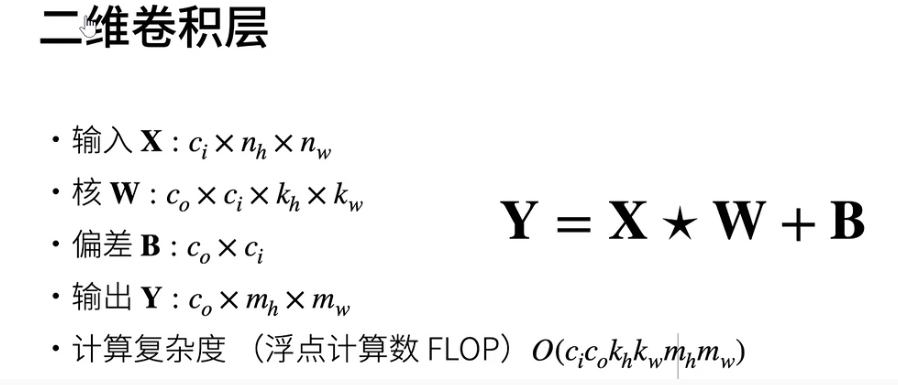